# Supplementary data analysis and figures
This notebook contains code to analyze paper reuslts and generate figures in the supplementary information for the paper __[Kinetic sequencing (*k*-Seq) as a massively parallel assay for ribozyme kinetics: utility and critical parameters](https://www.biorxiv.org/content/10.1101/2020.12.02.407346v1)__

## Environment setup

Set up the workspace environment

In [1]:
# Path to data downloaded from our Dryad deposit
PAPER_DATA_DIR = ''

# Path to output figures
FIG_OUTPUT_DIR = ''

# Path to k-seq repository (load k_seq package locally)
K_SEQ_REP_DIR = ''

# display resolution
DISP_RES = 80

In [3]:
# You wouldn't need to change this part

## Jedi autocompletion performs funky in Jupyter notebook, disable it
from IPython import get_ipython
get_ipython().Completer.use_jedi = False
get_ipython().Completer.limit_to__all__ = True


## Add repo path to load k-seq package locally (paper version)
from pathlib import Path
import sys
sys.path.insert(0, str(Path(K_SEQ_REP_DIR) / 'src'))
## Link data path and figure output path 
import os
os.environ['PAPER_DATA_DIR'] = PAPER_DATA_DIR
if PAPER_DATA_DIR != '':
    Path(FIG_OUTPUT_DIR).mkdir(exist_ok=True, parents=True)

import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = DISP_RES

marker_map = {'0': 'o', '1': 'o', '2': '^', '3': 's'}
color_map = {'R': '#AEAEAE', 'A': '#2C73B4', 'B': '#70C7C7',
             'C': '#1C7725', 'D':'#F39730', 'E': '#B2112A'}
from k_seq.utility import plot_tools
default_palette = plot_tools.Presets.color_cat10
label_map = {'A': '1250 μM', 'B': '250 μM', 'C': '50 μM', 
             'D': '10 μM', 'E': '2 μM',
             'R': 'Unreacted'}

## Figure S1: qPCR standard curves

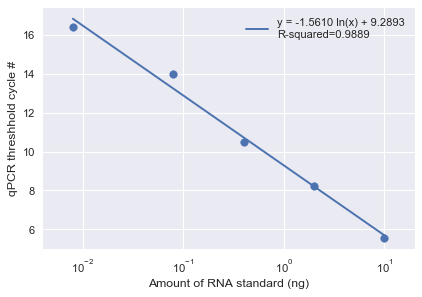

In [4]:
qPCR_sc = pd.read_csv(f'{PAPER_DATA_DIR}/data/qPCR-standard.csv')

plot_tools.regplot(
    x=qPCR_sc['Amount of RNA standard (ng)'], y=qPCR_sc['qPCR threshhold cycle #'],
    xlog=True, ylog=False
)
plt.gcf().savefig(f'{FIG_OUTPUT_DIR}/fig-s1.pdf')

## Figure S2: RNA quantification standard deviation

Percent standard deviation of total RNA amount
Measured by qPCR: 0.17604946652314918 (p-val = 0.05594296764147772)
Measured by spike-in: 0.1626817267478429 (p-val = 0.1348562388554613)


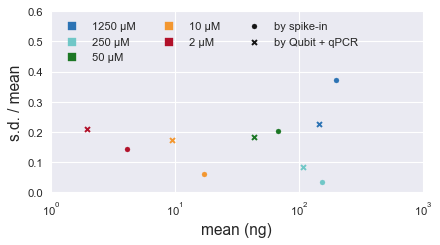

In [6]:
if 'byo_variant' not in locals().keys():
    from k_seq.utility import file_tools
    byo_variant = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-variant/byo-variant.pkl")
    byo_variant.update_analysis()

if 'dna_amount' not in locals().keys():
    dna_amount = byo_variant.analysis.sample_info()[['total amount (spike-in, ng)', 'total amount (sample total, ng)']]

pct_std = {'Qubit + qPCR': [], 'spike-in': []}

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for byo, color in color_map.items():
    samples = [sample for sample in dna_amount.index if sample[0] == byo]
    x_mean = dna_amount.loc[samples, 'total amount (spike-in, ng)'].mean()
    x_sd = dna_amount.loc[samples, 'total amount (spike-in, ng)'].std()
    y_mean = dna_amount.loc[samples, 'total amount (sample total, ng)'].mean()
    y_sd = dna_amount.loc[samples, 'total amount (sample total, ng)'].std()
    
    if byo != 'R':
        ax.scatter(x=[x_mean], y=[x_sd / x_mean],
                    marker='o', s=20, color=color)
        ax.scatter(x=[y_mean], y=[y_sd / y_mean],
                    marker='x', s=20, color=color)
        ax.scatter([], [], color=color, marker='s', s=50, label=label_map[byo])
        pct_std['Qubit + qPCR'].append(y_sd / y_mean)
        pct_std['spike-in'].append(x_sd / x_mean)
        
ax.scatter([],[], marker='o', s=20, color='#151515', label='by spike-in')  
ax.scatter([],[], marker='x', s=20, color='#151515', label='by Qubit + qPCR')
ax.set_xscale('log')
ax.set_xlim([1, 1000])
ax.set_ylim([0, 0.6])
ax.legend(loc='upper left', ncol=3)
ax.set_xlabel('mean (ng)', fontsize=14)
ax.set_ylabel('s.d. / mean', fontsize=14)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s2.pdf', bbox_inches='tight')

print('Percent standard deviation of total RNA amount')
print(f"Measured by qPCR: {np.mean(pct_std['Qubit + qPCR'])} (p-val = {np.std(pct_std['Qubit + qPCR'], ddof=1)})")
print(f"Measured by spike-in: {np.mean(pct_std['spike-in'])} (p-val = {np.std(pct_std['spike-in'], ddof=1)})")

## Figure S4 - S9: example fitting curves from simulated dataset

In [7]:
def load_results(path):
    """Load simulation fitting results and data"""
    x_data = pd.read_csv(f'{path}/data/x_values.csv', index_col=0, header=None)[1]
    y_dataframe = pd.read_csv(f'{path}/data/y_values.csv', index_col=0)
    y_dataframe.index = y_dataframe.index.astype(str)
    results = least_squares_batch.BatchFitResults.from_json(path, x_data=x_data, y_dataframe=y_dataframe)
    return results

def get_seq_subset(exp, kA_range=None, A_range=None, k_range=None):
    """Filter the sequences based on the range of kA, A, and k,
    Returns:
        pd.DataFrame of simulated sequence parameter for those satisfy the condition
    """

    flag = pd.Series(np.repeat(True, len(exp.parameters)), index=exp.parameters.index)
    if kA_range is not None:
        flag = flag & (exp.parameters.k * exp.parameters.A > kA_range[0]) & (exp.parameters.k * exp.parameters.A < kA_range[1])
    if k_range is not None:
        flag = flag & (exp.parameters.k > k_range[0]) & (exp.parameters.k < k_range[1])
    if A_range is not None:
        flag = flag & (exp.parameters.A > A_range[0]) & (exp.parameters.A < A_range[1])

    return exp.parameters[flag].index

def get_regions(exp=None, func=False):
    """Get 6 regions divided in simulation"""
    if func:
        from functools import partial
        return [
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(0.1, 1)),
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(1, 10)),
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(10, np.inf)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(0.1, 1)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(1, 10)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(10, np.inf))
        ]
    else:
        return [
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(0.1, 1)),
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(1, 10)),
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(10, np.inf)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(0.1, 1)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(1, 10)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(10, np.inf))
        ]

def simu_react_frac_example_curves_by_region(exps, seq_filter_fn, n_example=10, curve_type='bootstrap', figsize=None, fontsize=12, single_figsize=1.8, heatmap_resolution=100, save_to=None):
    """Plot example fitting curves and loss function map for sequence fitting results and conditioned provided in exps"""
    from k_seq.utility import plot_tools
    
    n_cond = len(exps)
    fig, axes = plt.subplots(2 * n_cond, n_example, figsize=(single_figsize * n_example * 1.1, single_figsize * 2 * n_cond))
    
    if curve_type.lower() in ['bs', 'bootstrap', 'bootstrapping']:
        plot_on='bootstrap'
    elif curve_type.lower() in ['conv', 'convergence', 'repeated fitting', 'rep fit']:
        plot_on='convergence'
    else:
        raise ValueError("Please pass 'bootstrap' or 'convergence' to curve_type")
    
    for ix, (name, exp) in enumerate(exps.items()):
        seq_list = seq_filter_fn(exp)
        
        if len(seq_list) > n_example:
            seq_list = np.random.choice(seq_list, size=n_example, replace=False)
        
        for seq, ax in zip(seq_list, axes[ix * 2]):
            exp.results.get_FitResult(seq).plot_fitting_curves(
                plot_on=plot_on, ax=ax, x_label='BYO (M)', 
                x_lim=(-0.0001, 0.002),
                fontsize=fontsize, y_label='react. frac.'
            )
            from math import ceil
            y_lim = ax.get_ylim()
            digits = int(np.log10(y_lim[1]))
            y_top = ceil(y_lim[1] / 10 ** digits * 10) * 10 ** digits / 10
            
            ax.set_ylim((y_lim[0], y_top))
            ax.set_yticks([0, y_top])
            ax.set_xticks([0, 0.002])
            ax.set_xticklabels(['0', '0.002'])
            
            
        for seq, ax in zip(seq_list, axes[ix * 2 + 1]):
            exp.results.get_FitResult(seq).plot_loss_heatmap(
                plot_on=plot_on, ax=ax,
                colorbar=False,
                fontsize=fontsize, add_lines=[1],
                tick_num=2, line_label=False,
                resolution=heatmap_resolution
            )
            ax.set_xticks([0, heatmap_resolution])
            ax.set_xticklabels(['$10^{-2}$', '$10^4$'])
            ax.set_yticks([0, heatmap_resolution])
            ax.set_yticklabels(['$10^{-3}$', '$10^{0}$'])
            
        fig.text(s=name, x=0, y=1 - (ix * 2 + 1) / (n_cond * 2), ha='right', va='center', fontsize=14, rotation=90)

    plt.tight_layout()

In [8]:
from k_seq.estimate.model_ident import ParamMap

simu_react_frac = {
    'Relative error = 0': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr0'),
    'Relative error = 0.2': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr02'),
    'Relative error = 0.5': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr05'),
    'Relative error = 1.0': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr10')
}

--------------------Region 1--------------------


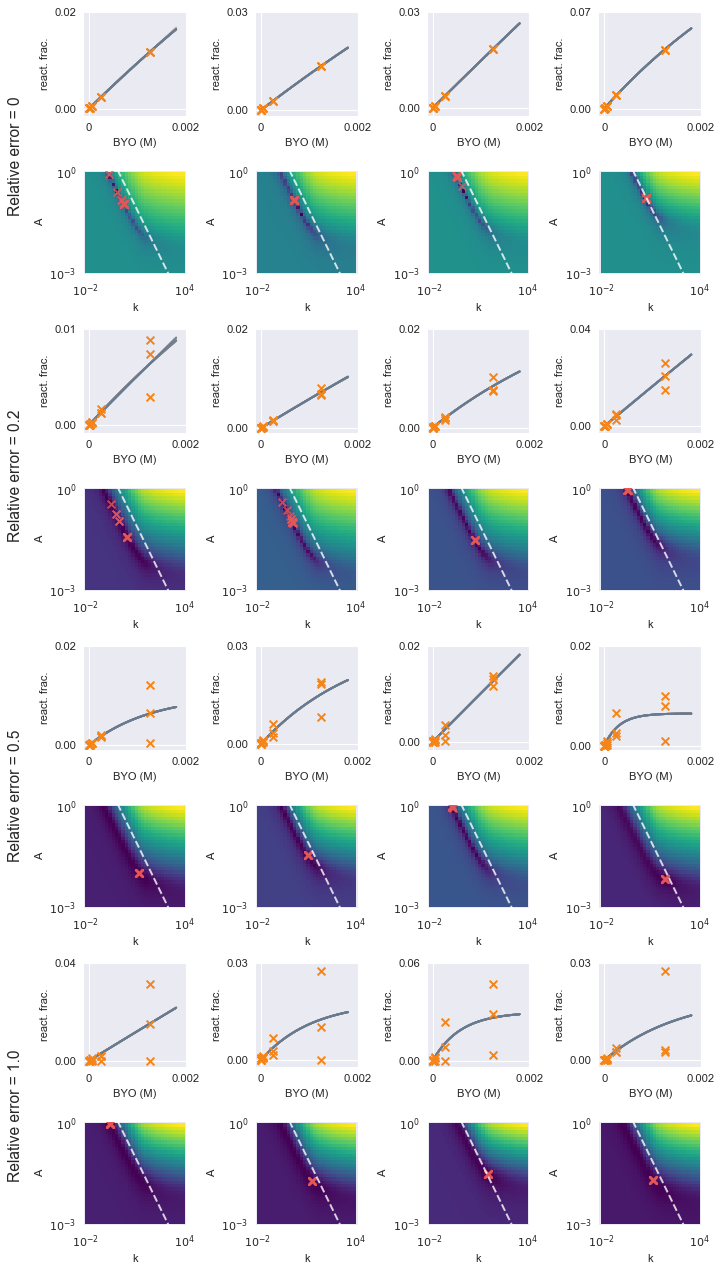

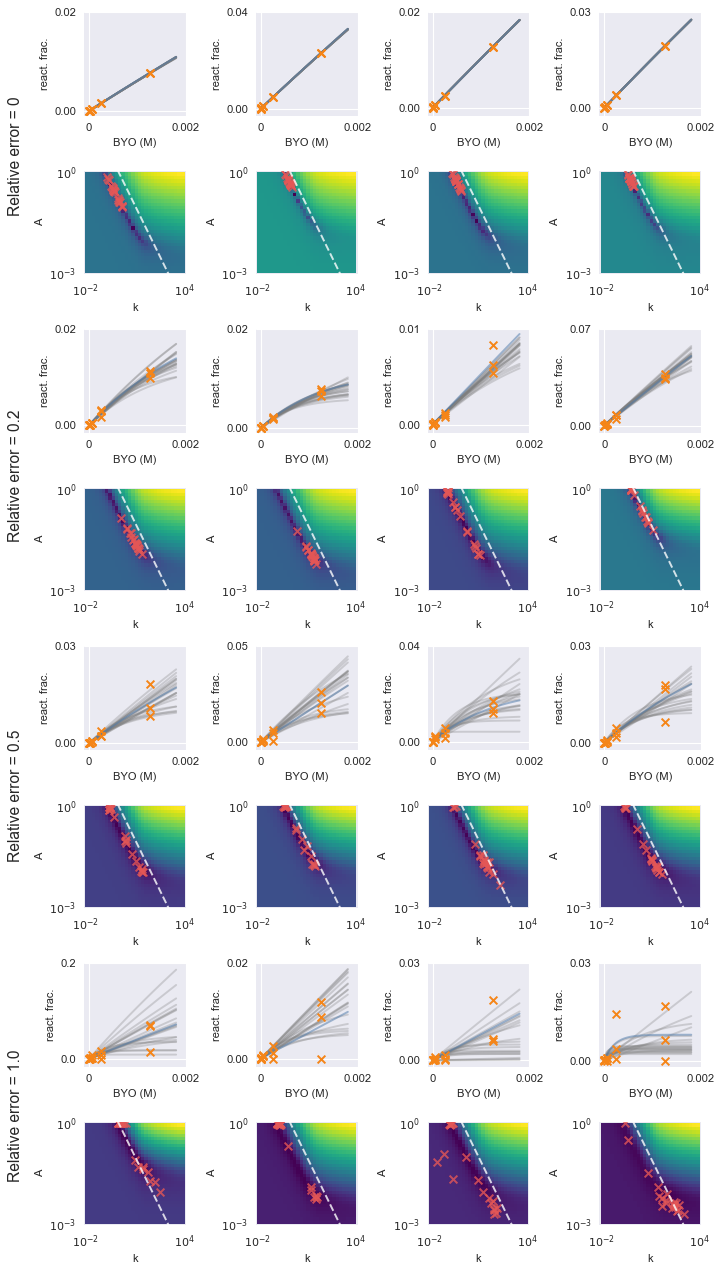

In [9]:
for ix, region in enumerate(get_regions(func=True)):
    print('-' * 20 + f'Region {ix + 1}' + '-' * 20)
    seq_list = simu_react_frac_example_curves_by_region(
        exps=simu_react_frac, seq_filter_fn=region, n_example=4,
        fontsize=10, single_figsize=2, curve_type='conv',
        heatmap_resolution=30
    )
    fig = plt.gcf()
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s{ix + 4}-a.pdf', dpi=600, bbox_inches='tight')
    seq_list = simu_react_frac_example_curves_by_region(
        exps=simu_react_frac, seq_filter_fn=region, n_example=4,
        fontsize=10, single_figsize=2, curve_type='bs',
        heatmap_resolution=30
    )
    fig = plt.gcf()
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s{ix + 4}-b.pdf', dpi=600, bbox_inches='tight')
    plt.show()

## Figure S10: compare model identifiability metric distribution

In [10]:
def metric_value_dist(exp, metric, vrange=None, label=None, bins=50, log=False,
                      ax=None, legend=False, conds=None, conds_formatter='cond {}', 
                      fontsize=12):
    """Plot a single histogram of sequence metric distribution, separated by conditions if provided"""
    from k_seq.utility import plot_tools
        
    metric_val = exp.get_metric_values(metric=metric, finite_only=True)
    if vrange is None:
        vrange = np.nanmin(metric_val), np.nanmax(metric_val)
    
    bins = np.logspace(np.log10(vrange[0]), np.log10(vrange[1]), bins) if log else np.linspace(vrange[0], vrange[1], bins)
    
    ax = plot_tools.ax_none(ax)
    if conds is None:
        ax.hist(metric_val, bins=bins, alpha=0.8)
    else:
        colors = plot_tools.Presets.color_tab10(len(conds))
        ax.hist([metric_val.reindex(cond) for cond in conds],
                bins=bins, color=colors, alpha=0.5, stacked=True,
                label=[conds_formatter.format(i + 1) for i in range(len(conds))])
    
    if log:
        ax.set_xscale('log')
        
    ax.set_xlim(vrange[0] * 0.9, vrange[1] * 1.1)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.3)
    if label is not None:
        ax.set_xlabel(label, fontsize=fontsize)
    
    if legend:
        ax.legend(ncol=2)
    
    return metric_val

def single_metric_value_dist_compare(exps, metric, label,
                                     bins=50, vrange=None, axes=None, 
                                     y_label=True, legend=True, fontsize=12):
    """Plot the histogram for metric value distribution, compare different results"""
    
    if vrange is None:
        vmin, vmax = 0, 0
        for exp in exps.values():
            metric_val = exp.get_metric_values(metric=metric, finite_only=True)
            metric_val = metric_val[np.isfinite(metric_val)]
            vmin = vmin if vmin < np.nanmin(metric_val) else np.nanmin(metric_val)
            vmax = vmax if vmax > np.nanmax(metric_val) else np.nanmax(metric_val)
    else:
        vmin, vmax = vrange
    
    if axes is None:
        fig, axes = plt.subplots(len(sep_map), 1, figsize=(6, 1.5 * len(sep_map)), 
                                 sharex='col')
    else:
        fig = plt.gcf()
    for ax, (name, exp) in zip(axes, exps.items()):
        metric_value_dist(exp=exp, metric=metric, vrange=(vmin, vmax),
                          label=None, bins=bins, conds_formatter='Region {}',
                          ax=ax, conds=get_regions(exp), fontsize=fontsize)
        ax.text(s=name, x=0.95, y=0.95, ha='right', va='top', fontsize=fontsize - 2, alpha=0.8,
                transform=ax.transAxes)
        ax.tick_params(labelsize=fontsize - 2)
    
    axes[-1].set_xlabel(label, fontsize=fontsize)
    if y_label:
        fig.text(s='Number of sequences', x=0.08, y=0.5, va='center', ha='right',
                 fontsize=fontsize, rotation=90)
    if legend:
        axes[-1].legend(loc=(1.05, 0), fontsize=fontsize)
#     plt.tight_layout()

def metrics_value_dist_compare(exps, metrics, labels, vrange=None, bins=50, fontsize=12):
    """Compare the metric distribution across different metrics"""
    
    fig, axes = plt.subplots(len(exps), len(metrics), 
                             figsize=(4 * len(metrics), 1.5 * len(exps)), sharex='col')
    for metric, label, ax in zip(metrics, labels, np.transpose(axes)):
        single_metric_value_dist_compare(exps, metric, label=label,
                                         bins=bins, axes=ax,
                                         legend=(metric == metrics[-1]), 
                                         y_label=(metric == metrics[0]),
                                         fontsize=fontsize)

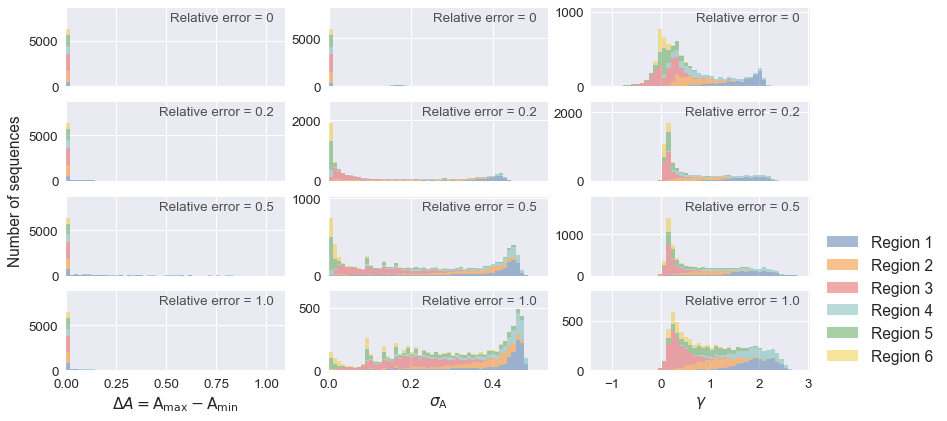

In [11]:
from k_seq.estimate.model_ident import gamma

metrics_value_dist_compare(
    exps=simu_react_frac, metrics=['conv_A_range', 'bs_A_std', gamma],
                           labels=['$\\Delta A = \\mathrm{{A}}_\\mathrm{{max}} - \\mathrm{{A}}_\\mathrm{{min}}$', '$\sigma_{{\mathrm{{A}}}}$', '$\\gamma$'], fontsize=14)

fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s10.pdf', bbox_inches='tight')

## Figure S11: distribution of model identifiability metrics and sample curves for sequences within different range of metric scores

In [12]:
def get_metric_values(exp, metric):
    if isinstance(metric, str):
        metric_val = exp.summary[metric]
    elif callable(metric):
        metric_val = exp.summary.apply(metric, axis=1)
    else:
        raise TypeError()
        
    return metric_val

def get_FitResult(seq, result):
    return result.get_FitResult(seq)


def sample_curves(result, metric, sample_bins, n_example=10, 
                  figsize=None, fontsize=12, single_figsize=1.8, seed=23, save_to=None,
                  heatmap_resolution=100,
                 ):
    """Plot example fitting curves and loss function map for sequence fitting results and conditioned provided in exps"""
    from k_seq.utility import plot_tools
    import multiprocessing as mp
    from functools import partial
    
    n_cond = len(sample_bins) - 1
    
    fig, axes = plt.subplots(2 * n_cond, n_example, 
                             figsize=(single_figsize * n_example * 1.1, single_figsize * 2 * n_cond))
    
    work_fn = partial(get_FitResult, result=result)
    
    for ix, start in enumerate(sample_bins[:-1]):
        seq_list = result.summary[(result.summary[metric] > start) & (result.summary[metric] < sample_bins[ix + 1])].index
        
        if len(seq_list) > n_example:
            np.random.seed(seed)
            seq_list = np.random.choice(seq_list, size=n_example, replace=False)
        
        with mp.Pool(8) as pool:
            fit_results = pool.map(work_fn, list(seq_list))
            
        for fit_result, ax in zip(fit_results, axes[ix * 2]):
            fit_result.plot_fitting_curves(plot_on='bootstrap', ax=ax, x_label='BYO (M)', 
                                           x_lim=(-0.0003, 0.002),
                                           fontsize=fontsize, y_label='react. frac.')
            from math import ceil
            y_lim = ax.get_ylim()
            digits = int(np.log10(y_lim[1]))
            y_top = ceil(y_lim[1] / 10 ** digits * 10) * 10 ** digits / 10
            
            ax.set_ylim((y_lim[0], y_top))
            ax.set_yticks([0, y_top])
            ax.set_xticks([0, 0.002])
            ax.set_xticklabels(['0', '0.002'])
            
            
        for fit_result, ax in zip(fit_results, axes[ix * 2 + 1]):
            fit_result.plot_loss_heatmap(
                plot_on='bootstrap', ax=ax,
                colorbar=False,
                fontsize=fontsize, add_lines=[1],
                tick_num=2,
                resolution=heatmap_resolution
            )
            ax.set_xticks([0, heatmap_resolution])
            ax.set_xticklabels(['$10^{-2}$', '$10^4$'])
            ax.set_yticks([0, heatmap_resolution])
            ax.set_yticklabels(['$10^{-3}$', '$10^{0}$'])

            
        fig.text(s=f"{start:.2f} ~ {sample_bins[ix + 1]:.2f}", x=0, y=1 - (ix * 2 + 1) / (n_cond * 2), ha='right', va='center', fontsize=14, rotation=90)

    plt.tight_layout()
    return fig

In [14]:
from k_seq.estimate.model_ident import gamma
from k_seq.estimate import least_squares_batch

variant_pool_results_double_mutants = least_squares_batch.BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/double-mutants_bs-100')
variant_pool_results_double_mutants.summary['gamma'] = gamma(variant_pool_results_double_mutants.summary)

/usr/local/var/pyenv/versions/k-seq/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/var/pyenv/versions/k-seq/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


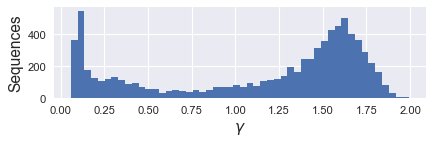

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
ax.hist(variant_pool_results_double_mutants.summary['gamma'], bins=50)
ax.set_xlabel('$\gamma$', fontsize=14)
ax.set_ylabel('Sequences', fontsize=14)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-a.pdf', bbox_inches='tight')
plt.show()

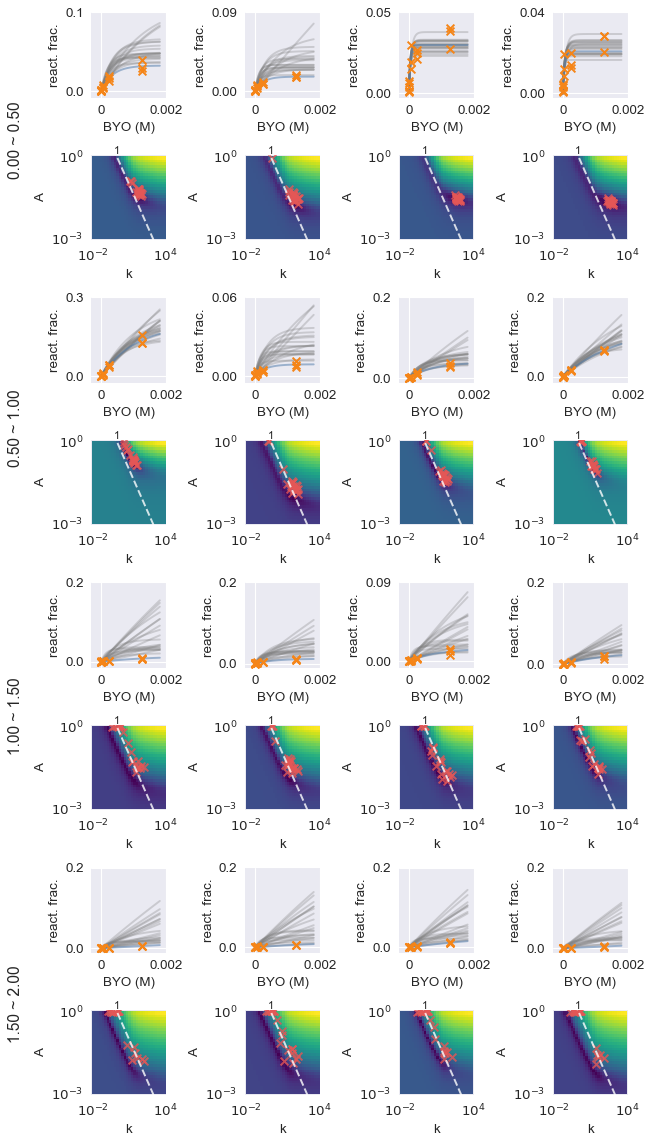

In [17]:
fig = sample_curves(
    result=variant_pool_results_double_mutants, metric='gamma',
    sample_bins= [0, 0.5, 1.0, 1.5, 2], n_example=4, 
    figsize=None, fontsize=12, single_figsize=1.8, save_to=None,
    heatmap_resolution=30
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-c.pdf', bbox_inches='tight', dpi=600)

/usr/local/var/pyenv/versions/k-seq/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/var/pyenv/versions/k-seq/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


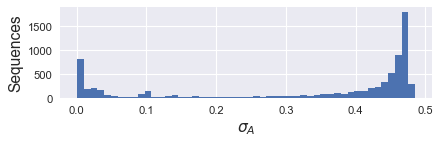

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
ax.hist(variant_pool_results_double_mutants.summary['bs_A_std'], bins=50)
ax.set_xlabel('$\sigma_{A}$', fontsize=14)
ax.set_ylabel('Sequences', fontsize=14)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-b.pdf', bbox_inches='tight')
plt.show()

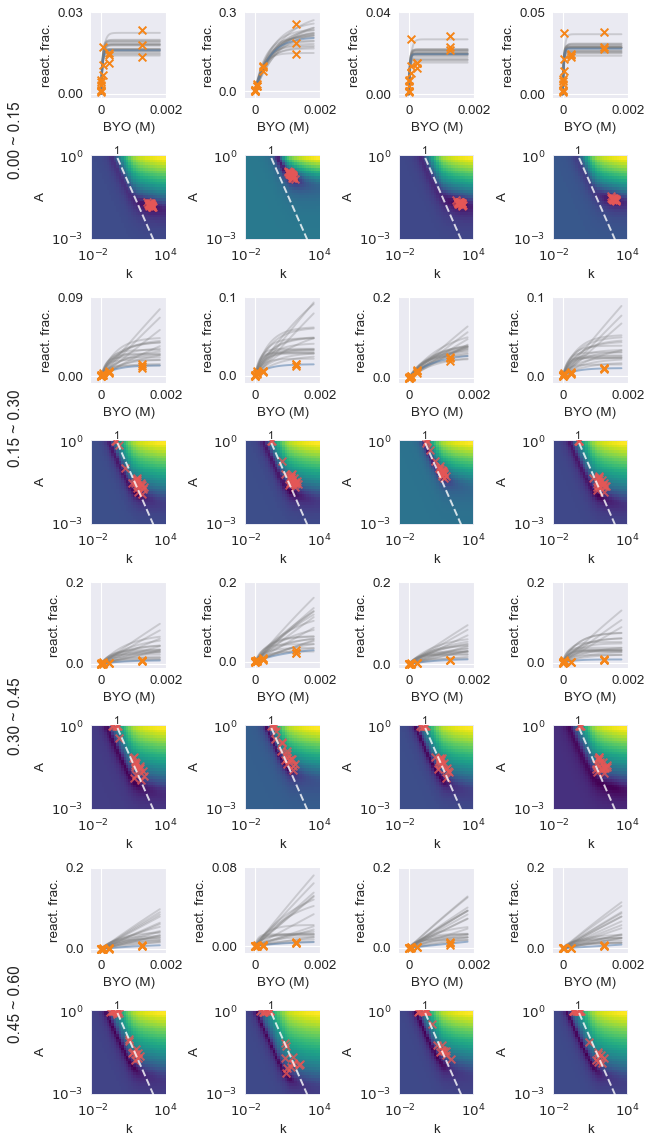

In [19]:
fig = sample_curves(
    result=variant_pool_results_double_mutants, metric='bs_A_std', sample_bins= [0, 0.15, 0.3, 0.45, 0.6], n_example=4, 
    figsize=None, fontsize=12, single_figsize=1.8, save_to=None,
    heatmap_resolution=30
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-d.pdf', bbox_inches='tight', dpi=600)

## Figure S12: alignment of two model identifiability metrics in sequences from BYO-variant pool

In [20]:
from k_seq.estimate import least_squares_batch

if 'variant_pool_results' not in locals().keys():
    variant_pool_results = least_squares_batch.BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/all-seq_bs-100')

variant_pool_results.summary['gamma'] = gamma(variant_pool_results.summary)
variant_pool_results.summary.loc[variant_pool_results.summary.index.isin(variant_pool_results_double_mutants.summary.index), 'Type'] = 'd ≤ 2'
variant_pool_results.summary.loc[~variant_pool_results.summary.index.isin(variant_pool_results_double_mutants.summary.index), 'Type'] = 'd > 2'

SpearmanrResult(correlation=0.9454343863424508, pvalue=0.0)


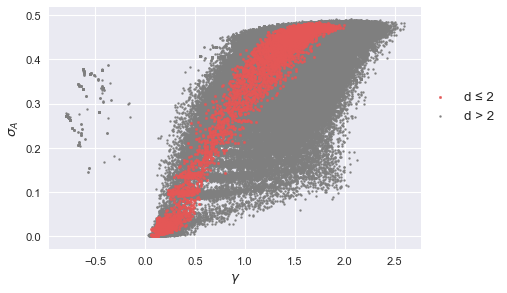

In [21]:
# Calculate spearman r for sequences within double mutants
from scipy import stats
gamma = variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd ≤ 2', 'gamma']
sigma_A = variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd ≤ 2', 'bs_A_std']
spearman_r = stats.spearmanr(gamma[~gamma.isna()], sigma_A[~sigma_A.isna()])
print(spearman_r)

# plot scatter alignment
fig, ax = plt.subplots(1, 1, figsize=(6, 4))                                       
ax.scatter(
    variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd ≤ 2', 'gamma'],
    variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd ≤ 2', 'bs_A_std'],
    alpha=1, s=5, color='#E45756', label = 'd ≤ 2', zorder=5
)

ax.scatter(
    variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd > 2', 'gamma'],
    variant_pool_results.summary.loc[variant_pool_results.summary['Type'] == 'd > 2', 'bs_A_std'],
    alpha=1, s=3, color='#7F7F7F', label = 'd > 2', zorder=1
)

ax.set_xlabel('$\gamma$', fontsize=12)
ax.set_ylabel('$\sigma_A$', fontsize=12)

ax.legend(loc=(1, 0.5), fontsize=12)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s12.png', dpi=600, bbox_inches='tight')
plt.show()

## Figure S13: DNA sequencing reads processing

In [24]:
def survey_raw_reads(reads_tsv):
    # add raw reads
    raw_reads = pd.read_csv(reads_tsv, sep='\t')
    sample_reads = raw_reads[raw_reads['R'] == 1].groupby('file').sum()
    raw_reads_fw = sample_reads['reads'].rename(rename_res)
    sample_reads = raw_reads[raw_reads['R'] == 2].groupby('file').sum()
    raw_reads_bw = sample_reads['reads'].rename(rename_res)
    
    raw_reads_fw.index.name = 'sample'
    raw_reads_bw.index.name = 'sample'
    raw_reads_fw.name = 'Forward'
    raw_reads_bw.name = 'Backward'
    
    return raw_reads_fw, raw_reads_bw


def get_total_and_unique(table):
    return table.sum(axis=0), (table > 0).sum(axis=0)

def rename_res(name):
    """Rename results loaded from raw reads and samples as
    
    A1/d-A1_S1 --> 1250uM-1
    ...
    R/R0 --> input
    """
    
    if len(name) > 2:
        name = name.split('_')[0].split('-')[-1]
    
    if 'R' in name:
        return 'Unreacted'
    else:
        concen_mapper = {
            'A': '1250',
            'B': '250',
            'C': '50',
            'D': '10',
            'E': '2'
        }
        return "{} μM-{}".format(concen_mapper[name[0]], name[1])

from k_seq.utility.func_tools import AttrScope
from k_seq.data import seq_data
import os

reads = AttrScope(raw_reads=None,
                  joined_total=None, joined_unique=None,
                  filtered_total=None, filtered_unique=None,
                  valid_total=None, valid_unique=None)

raw_reads_path = f'{PAPER_DATA_DIR}/data/byo-variant/fastq/sample_reads.tsv'

# add raw reads
reads.raw_reads = pd.concat(survey_raw_reads(reads_tsv=raw_reads_path), axis=1)

if 'byo_variant' not in locals().keys():
    from k_seq.utility import file_tools
    byo_variant = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-variant.pkl")
    byo_variant.update_analysis()
    
seq_table = byo_variant
reads.joined_total, reads.joined_unique = get_total_and_unique(byo_variant.table.original)

# Add filtered
reads.filtered_total, reads.filtered_unique = get_total_and_unique(byo_variant.table.filtered)

# Add analyzable

reads.analyzable_total, reads.analyzable_unique = get_total_and_unique(byo_variant.table.original.loc[byo_variant.table.reacted_frac_qpcr.index])

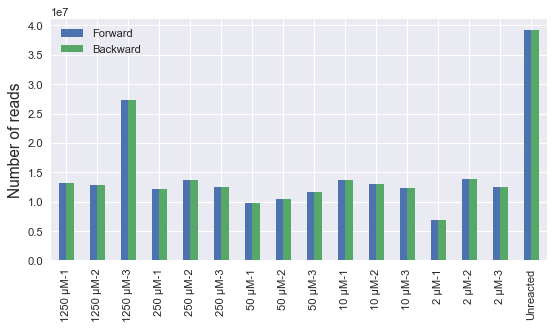

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = reads.raw_reads.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of reads', fontsize=14)
ax.set_xlabel('')
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-a.pdf', bbox_inches='tight')
plt.show()


joined
Unique sequences: 464851.0 (758641.849134623)
Unreacted samples: 3286996
Reacted samples: 276708.0 (99136.48640564756)
filtered
Unique sequences: 369017.375 (592936.8494957817)
Unreacted samples: 2574058
Reacted samples: 222014.66666666666 (78948.67708533062)
analyzable
Unique sequences: 203664.625 (158227.62331269257)
Unreacted samples: 764756
Reacted samples: 166258.53333333333 (53270.16397688118)


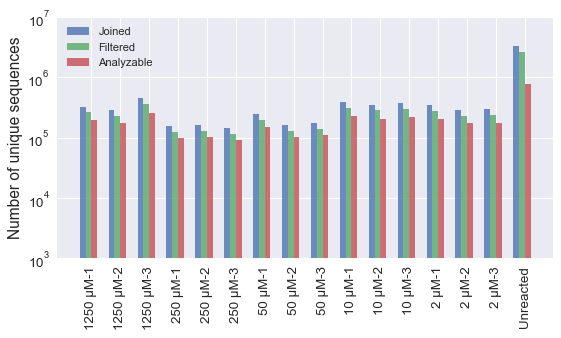

joined
Total reads: 90.87711898823842 (1.658328608458402)
Unreacted samples: 84.99297246064818
Reacted samples: 91.2693954234111 (0.5554543971537748)
filtered
Total reads: 87.94619965617844 (1.1423537098638488)
Unreacted samples: 84.11366673270044
Reacted samples: 88.20170185107696 (0.5282755499252247)
analyzable
Total reads: 87.11974628642162 (2.534823133201898)
Unreacted samples: 77.87040782204923
Reacted samples: 87.73636885071309 (0.6051158046672062)


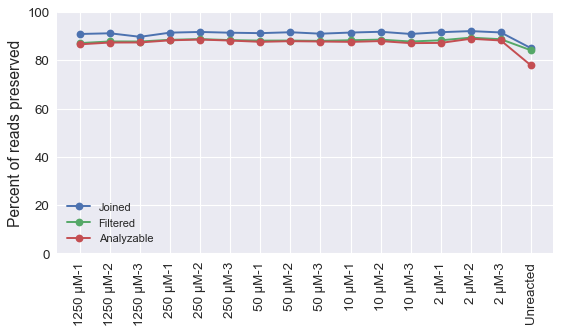

In [26]:
stages = ['joined', 'filtered', 'analyzable']

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pos = np.arange(reads.filtered_total.shape[0]) * (len(stages) + 2)

# plot each stage
for ix, stage in enumerate(stages):
    x = pos + ix + 1
    
    # add barplot on unique sequences
    y = getattr(reads, stage + '_unique')
    y = y.rename(index=rename_res)
    ax.bar(x=x, height=y, width=1, align='center', label=stage.title(), alpha=0.8, zorder=1)
    
    # print summary
    print(stage)
    print(f"Unique sequences: {y.mean()} ({y.std()})")
    print(f"Unreacted samples: {y[-1]}")
    print(f"Reacted samples: {y[:-1].mean()} ({y[:-1].std()})")
    
    
ax.set_ylabel('Number of unique sequences', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_yscale('log')
ax.set_ylim([1e3, 1e7])
ax.set_xticks(pos + 1 + len(stages) / 2)
ax.legend()
ax.set_xticklabels(reads.raw_reads.index.values, fontsize=12, rotation=90)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-c.pdf', bbox_inches='tight')

plt.show()

########
stages = ['joined', 'filtered', 'analyzable']

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pos = np.arange(reads.filtered_total.shape[0]) * (len(stages) + 2)

# plot each stage
for ix, stage in enumerate(stages):
    x = pos
    
    # add scatterplot on the fraction of total reads
    joined_ratio = getattr(reads, stage + '_total').rename(index=rename_res)
    joined_ratio = joined_ratio.divide(reads.raw_reads['Forward']) * 100
    ax.plot(x, joined_ratio, marker='o', zorder=10, label=stage.title())
    # print summary
    print(stage)
    print(f"Total reads: {joined_ratio.mean()} ({joined_ratio.std()})")
    print(f"Unreacted samples: {joined_ratio[-1]}")
    print(f"Reacted samples: {joined_ratio[:-1].mean()} ({joined_ratio[:-1].std()})")
    
    
ax.set_ylabel('Percent of reads preserved', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim([0, 100])
ax.set_xticks(pos)
ax.legend()
ax.set_xticklabels(joined_ratio.index.values, fontsize=12, rotation=90)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-c.pdf', bbox_inches='tight')

plt.show()

## Figure S14: doped pool design

In [27]:
from k_seq.data import variant_pool
mutation_rate_list = np.linspace(1e-2, 0.4, 50)
mutation_order_list = pd.Series(np.arange(6), index=np.arange(6))

dopedpool_tables = {
    'single_seq_fraction': pd.DataFrame(index=mutation_order_list),
    'num_of_unique_seqs': pd.DataFrame(index=mutation_order_list),
    'order_fraction': pd.DataFrame(index=mutation_order_list),
    'seq_counts_in_10M': pd.DataFrame(index=mutation_order_list)
}

for mutation_rate in mutation_rate_list:
    from functools import partial    
    dopedpool_tables['single_seq_fraction'][mutation_rate] = mutation_order_list.apply(partial(variant_pool.d_mutant_fraction, mutation_rate=mutation_rate))
    
    dopedpool_tables['num_of_unique_seqs'][mutation_rate] = mutation_order_list.apply(variant_pool.num_of_seq)
    
    dopedpool_tables['order_fraction'][mutation_rate] = dopedpool_tables['single_seq_fraction'][mutation_rate] * dopedpool_tables['num_of_unique_seqs'][mutation_rate]
    
dopedpool_tables['seq_counts_in_10M'] = 10e6 * dopedpool_tables['single_seq_fraction']

In [28]:
print("Fraction of reads")
for order in [0, 1, 2]:
    print(f"d = {order}: {variant_pool.d_mutant_fraction(order, 0.09)}")

Fraction of reads
d = 0: 0.1379968708756601
d = 1: 0.0045493473915052774
d = 2: 0.00014997848543423992


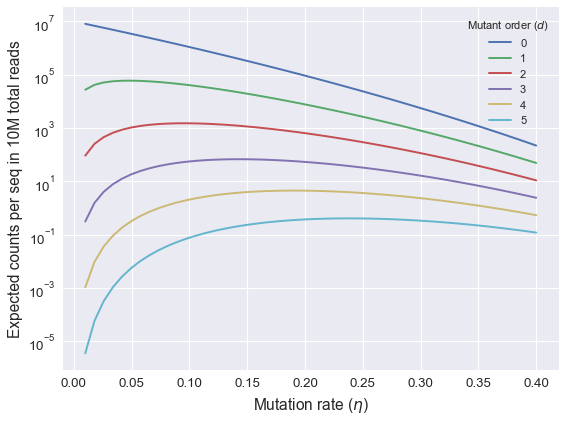

In [29]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
dopedpool_tables['seq_counts_in_10M'].transpose().plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Mutation rate ($\\eta$)', fontsize=14)
ax.set_ylabel('Expected counts per seq in 10M total reads', fontsize=14)
ax.legend(title='Mutant order ($d$)', loc='upper right')
ax.tick_params(labelsize=12)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s14.pdf')
plt.show()

## Figure S15: expected fraction of reads from neighboring sequences

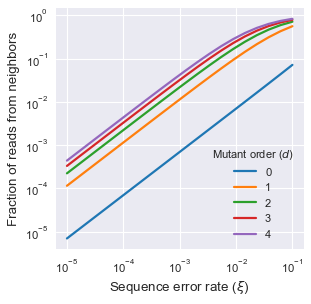

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for d, color in zip([0, 1, 2, 3, 4], default_palette(num=5)):
    xi = np.logspace(-5, -1, 20)
    ax.plot(xi, variant_pool.neighbor_effect_error(xi, d=d), label=d, lw=2, color=color)

ax.set_xlabel('Sequence error rate ($\\xi$)', fontsize=12)
ax.set_ylabel('Fraction of reads from neighbors', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Mutant order ($d$)', fontsize=10)
ax.tick_params(labelsize=10)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s15.pdf', bbox_inches='tight')

plt.show()

## Figure S16: uncertainty accuracy vs sequences with different kA

In [31]:
if 'simu_count' not in locals().keys():
    from k_seq.data import simu
    simu_count = simu.SimulationResults(
        dataset_dir=f"{PAPER_DATA_DIR}/results/simu-count/simu-count.pkl",
        result_dir=f'{PAPER_DATA_DIR}/results/simu-count/all-seq_bs-100/'
    )

INFO:root:1000000 sequences simulated, 602268 fitted, 602246 has valid results


In [33]:
def uncertainty_accuracy_seq_bins(accuracy, bin_by, bin_size=5000):
    accuracy = accuracy.sort_values(by=bin_by, ascending=False)
    bin_num = int(accuracy.shape[0] / bin_size)
    acc_list = [accuracy.iloc[ix * bin_size : (ix + 1) * bin_size]['in_ci95'].mean() for ix in range(bin_num)]
    N_list = [(ix + 1) * bin_size for ix in range(bin_num)]
    return acc_list, N_list, accuracy


def plot_uncertainty_accuracy_seq_bins(result, bin_by, pred_types, 
                                       param='kA', bin_by_label=None, bin_size=1000, 
                                       ax=None, figsize=(6, 4), fontsize=12):
    
    composed = {}
    # line plot
    ax = plot_tools.ax_none(ax=ax, figsize=figsize)
    color_list = plot_tools.Presets.color_tab10(len(pred_types))
    
    if isinstance(pred_types, (list, tuple)):
        pred_types = {pred_type: pred_type for pred_type in pred_types}
    
    for (pred_type_label, pred_type), color in zip(pred_types.items(), color_list):
        acc_list, N_list, accuracy = uncertainty_accuracy_seq_bins(
            accuracy=result.get_uncertainty_accuracy(param=param, pred_type=pred_type),
            bin_by=bin_by, bin_size=bin_size
        )
        composed[pred_type_label] = np.mean(accuracy['in_ci95'])
        
        ax.plot(N_list, acc_list, '-o', markersize=5, color=color, alpha=0.5, label=pred_type_label)
    
    
    ax.set_xlabel(f'Sequences (ordered by {bin_by if bin_by_label is None else bin_by_label})',
                  fontsize=fontsize)
    ax.set_ylabel('Fraction of truth in CI-95', 
                  fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [0.95, 0.95], 'k', ls='--', alpha=0.5, zorder=1)
    ax.set_xlim(xlim[0], xlim[1])
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    ax.legend()
    
    return composed, ax

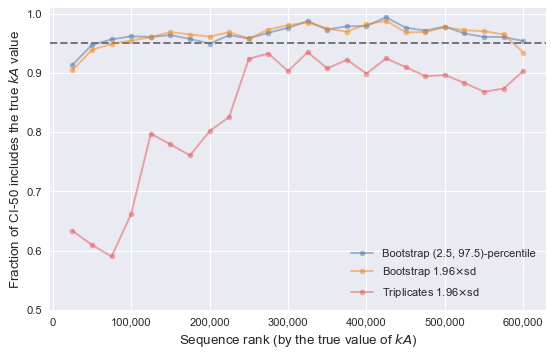

In [34]:
comp_all, ax = plot_uncertainty_accuracy_seq_bins(
    result=simu_count,
    bin_by='kA_truth', bin_by_label='kA true value',
    pred_types={'Bootstrap (2.5, 97.5)-percentile':'bs_ci95',
                "Bootstrap 1.96$\\times$sd":'bs_sd',
                "Triplicates 1.96$\\times$sd": 'rep_sd'},
    figsize=(8, 5),
    param='kA', bin_size=25000
)
from matplotlib import ticker
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel('Sequence rank (by the true value of $kA$)')
ax.set_ylabel('Fraction of CI-50 includes the true $kA$ value')
ax.set_ylim(0.5, 1.01)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s16.pdf', bbox_inches='tight')

## Figure S17: precision vs kA

In [35]:
def scatter_plot_results_on_mutation_dist(result, x, y, x_label, y_label, x_lim, y_lim, x_log=True, y_log=True, top_group_size=int(1e4), top_y_values=None, fontsize=14):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    w_list = {'$d = 0$': lambda df: df['dist_to_center'] == 0,
              '$d = 1$': lambda df: df['dist_to_center'] == 1,
              '$d = 2$': lambda df: df['dist_to_center'] == 2,
              '$d = 3$': lambda df: df['dist_to_center'] == 3,
              '$d \geq 4$': lambda df: df['dist_to_center'] >= 4}

    color_list = plot_tools.Presets.color_tab10(len(w_list))

    for ix, ((label, filter_fn), color) in enumerate(zip(w_list.items(), color_list)):
        seq_list = result[filter_fn(result)].index
        if len(seq_list) > top_group_size:
            seq_list = seq_list.to_series().sample(top_group_size)
        x_series = result.loc[seq_list, x]
        y_series = result.loc[seq_list, y]
        if top_y_values is not None:
            y_series[y_series > top_y_values] = top_y_values
        ax.scatter(x_series, y_series,
                   marker='o', s=20 -  ix ** 2, color=color, label=label, alpha=1 - 0.15 * ix, zorder = 8 - ix)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend()

In [36]:
if 'variant_pool_results' not in locals().keys():
    variant_pool_results = least_squares_batch.BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/all-seq_bs-100')
    
if 'byo_variant' not in locals().keys():
    byo_variant = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-variant/byo-variant.pkl")
    byo_variant.update_analysis()

variant_pool_results.summary['dist_to_center'] =  variant_pool_results.summary.index.to_series().map(byo_variant.pool_peaks_merged.dist_to_center)

variant_pool_results.summary['kA_fold_range'] = variant_pool_results.summary['bs_kA_97.5%'] / variant_pool_results.summary['bs_kA_2.5%']

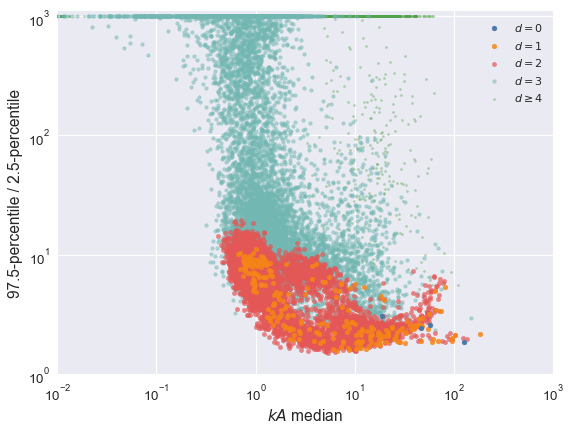

In [37]:
scatter_plot_results_on_mutation_dist(
    result=variant_pool_results.summary, x = 'bs_kA_50%', y = 'kA_fold_range',
    x_label = '$kA$ median', y_label = '97.5-percentile / 2.5-percentile',
    x_log = True, y_log = True, x_lim = (1e-2, 1e3), y_lim = (1, 1.1e3),
    fontsize = 14, top_group_size = int(1e4), top_y_values = 1e3
)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s17.pdf', bbox_inches='tight')

## Figure S18: accuracy of kA estimation vs. counts in the unreacted pool

In [38]:
def scatter_ratio_to_truth(df_res, df_truth, xcol, seq_list=None, ycol='ka', cap_by=100, fold_guide_lines=(1.1, 10),
                   markercolor='#2C73B4', alpha=0.3,
                   xlog=False, ylog=False, xlabel=None, ylabel=None, xlim=None, ylim=None,
                   markersize=5, ax=None, figsize=None, fontsize=14):
    """Scatterplot of error distribution with respect to given x axis
    Args:
        df_res (pd.DataFrame): table of results from estimation
        df_truth (pd.DataFrame): table of ground truth to compare with
        xcol (str): column name in df_truth to use as x axis
        ycol (str or tuple (str, str)): column name(s) in df_res and df_truth to compare
        percent_error (bool): if calculate percent error based on the true values
    """
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize if figsize else [8, 4])
    
    if isinstance(ycol, str):
        # if y column name is same in the results and truth table
        ycol = (ycol, ycol)
    
    if seq_list is not None:
        df_res = df_res.loc[seq_list]
        df_truth = df_truth.loc[seq_list]
    
    est = df_res[ycol[0]]
    truth = df_truth[ycol[1]]
    ratio = est / truth
    ratio[ratio > cap_by] = cap_by
    ratio[ratio < 1/cap_by] = 1/cap_by
    ylabel_prefix = 'Estimation / truth for'
    x = df_truth[xcol]
    ax.scatter(x, ratio, color=markercolor, marker='.', s=markersize, alpha=alpha)
    
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel if xlabel else xcol, fontsize=fontsize)
    ax.set_ylabel(ylabel if ylabel else f"{ylabel_prefix} ${ycol[0]}$", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    
    
    if not xlim:
        xlim = ax.get_xlim()
    if fold_guide_lines:
        if isinstance(fold_guide_lines, (int, float, tuple)):
            fold_guide_lines = [fold_guide_lines]
        for fold_guide_line in fold_guide_lines:
            if isinstance(fold_guide_line, tuple):
                value, label = fold_guide_line[0], fold_guide_line[1]
            else:
                value, label = fold_guide_line, str(fold_guide_line)
            ax.plot(xlim, (value, value), 'k--', alpha=0.5)
            ax.text(s=label, x=xlim[1], y=value, ha='left', va='center', fontsize=fontsize - 4)

    ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()
    return fig

In [39]:
if 'simu_count' not in locals().keys():
    from k_seq.data import simu
    simu_count = simu.SimulationResults(
        dataset_dir=f"{PAPER_DATA_DIR}/results/simu-count/simu-count.pkl",
        result_dir=f'{PAPER_DATA_DIR}/results/simu-count/all-seq_bs-100/'
    )

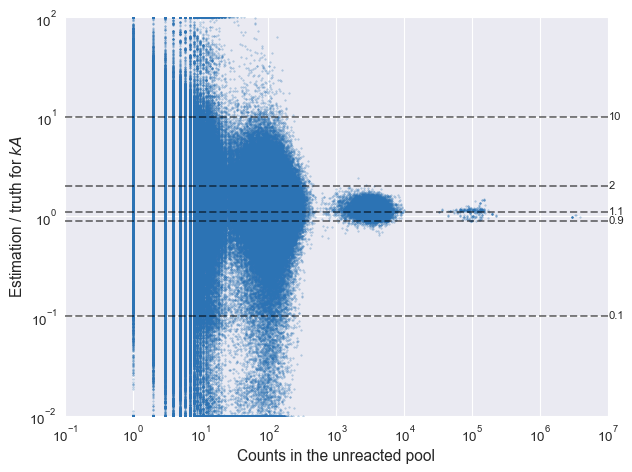

In [40]:
fig = scatter_ratio_to_truth(
    df_res=simu_count.results, df_truth=simu_count.truth,
    seq_list=simu_count.seq_list, xcol='input_counts', ycol=('kA', 'kA'),
    xlog=True, ylog=True, xlabel='Counts in the unreacted pool',
    ylim=(1e-2, 1e2), xlim=(1e-1, 1e7), figsize=(8, 6), markersize=10,
    cap_by=100, fold_guide_lines=[0.1, 0.9, 1.1, 2, 10],
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s18.png', dpi=600)

## Figure S19: pool evenness (variant pool vs. enriched pool)

In [41]:
def entropy(x, min_counts=0):
    x = np.array(x)
    x = x[x > min_counts]
    x = x / x.sum()
    return - np.sum(x * np.log(x))
def normalized_entropy(x, min_counts):
    x = np.array(x)
    return entropy(x, min_counts=min_counts) / np.log(len(x > min_counts))

In [42]:
if 'byo_variant' not in locals().keys():
    from k_seq.utility import file_tools
    byo_variant = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-varaint/byo-variant.pkl")
    byo_variant.update_analysis()
    
    
if 'byo_enriched' not in locals().keys():
    from k_seq.utility import file_tools
    byo_enriched = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-enriched/byo-enriched.pkl")
    byo_enriched.update_analysis()

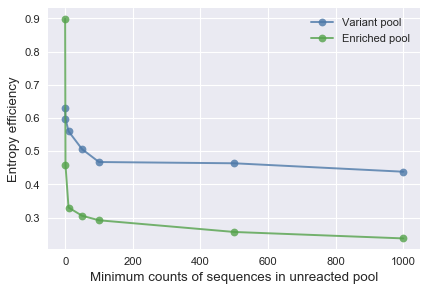

In [43]:
min_counts_list = [0, 1, 10, 50, 100, 500, 1000]

variant_pool = [normalized_entropy(byo_variant.table.filtered['R0'], min_counts=min_counts) for min_counts in min_counts_list]
enriched_pool = [normalized_entropy(byo_enriched.table.nf_filtered['R0'], min_counts=min_counts) for min_counts in min_counts_list]


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(min_counts_list, variant_pool, marker='o', color='#4C78A8', alpha=0.8, label='Variant pool')
ax.plot(min_counts_list, enriched_pool, marker='o', color='#54A24B', alpha=0.8, label='Enriched pool')
ax.set_xlabel('Minimum counts of sequences in unreacted pool', fontsize=12)
ax.set_ylabel('Entropy efficiency', fontsize=12)
ax.legend()


fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s19.pdf', bbox_inches='tight')
plt.show()
